# 2.06: Model Performance Diagnostics - Executive Level

## OPENING

Alright — we've computed metrics, we've built the scoreboard, and we've compared our baselines.

But here's the thing: **No model is signed off yet.**

Before we deploy anything — before we call a baseline "good enough" — we need due diligence. This is inspection before deployment.

Even if a baseline passes the Sufficiency Gate, diagnostics are required for risk management.

Executives don't want 30,000 individual SKU metrics. They want a system health report. They want to know: **Where is the fire?**

This notebook takes us from scoreboard rankings to diagnostic triage — the repeatable workflow real forecasting teams use to assess health at the portfolio level.

## SETUP: Load Dependencies and Data

In [123]:
import sys
from pathlib import Path

print("=" * 70)
print("DIAGNOSTIC: Python Environment Setup")
print("=" * 70)

print(f"\n1. Python Interpreter:")
print(f"   sys.executable: {sys.executable}")
is_venv = ".venv" in sys.executable
print(f"   Using Poetry venv: {is_venv} {'✓' if is_venv else '✗ WARNING: Not using Poetry venv!'}")

print(f"\n2. Current Working Directory:")
print(f"   Path.cwd(): {Path.cwd()}")

print(f"\n3. Module and Project Root Resolution:")
MODULE_DIR = Path.cwd()
PROJECT_ROOT = MODULE_DIR.parent.parent
print(f"   MODULE_DIR: {MODULE_DIR}")
print(f"   PROJECT_ROOT: {PROJECT_ROOT}")
print(f"   PROJECT_ROOT exists: {PROJECT_ROOT.exists()} {'✓' if PROJECT_ROOT.exists() else '✗'}")
print(f"   src dir exists: {(PROJECT_ROOT / 'src').exists()} {'✓' if (PROJECT_ROOT / 'src').exists() else '✗'}")

print(f"\n4. sys.path (first 5 entries):")
for i, path in enumerate(sys.path[:5]):
    print(f"   [{i}] {path}")
project_in_path = any(str(PROJECT_ROOT) in path for path in sys.path)
print(f"   PROJECT_ROOT in sys.path: {project_in_path} {'✓' if project_in_path else '✗'}")

print(f"\n5. Attempting to import src module:")
sys.path.insert(0, str(PROJECT_ROOT))
try:
    from src import CacheManager, ArtifactManager, get_notebook_name, find_project_root
    print(f"   ✓ Successfully imported from src")
except ImportError as e:
    print(f"   ✗ Failed to import from src: {e}")

print("\n" + "=" * 70)

DIAGNOSTIC: Python Environment Setup

1. Python Interpreter:
   sys.executable: /Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations/.venv/bin/python
   Using Poetry venv: True ✓

2. Current Working Directory:
   Path.cwd(): /Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations/notebooks/module_02_baselines

3. Module and Project Root Resolution:
   MODULE_DIR: /Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations/notebooks/module_02_baselines
   PROJECT_ROOT: /Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations
   PROJECT_ROOT exists: True ✓
   src dir exists: True ✓

4. sys.path (first 5 entries):
   [0] /Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations
   [1] /Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations
   [2] /Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations
   [3] /Users/jackrodenberg/Desktop/real-world-forecas

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tsforge as tsf 
# --- Local Imports ---
from src import (
    CacheManager,
    ArtifactManager,
    get_notebook_name,
    find_project_root,
)
from src.metrics import MetricsCalculator, MetricResults

# --- Settings ---
plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option('display.float_format', '{:.4f}'.format)

# --- Paths ---
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

# --- Managers ---
NB_NAME = get_notebook_name()
cache = CacheManager(PROJECT_ROOT / ".cache" / NB_NAME)
artifacts = ArtifactManager(PROJECT_ROOT / "artifacts")


In [125]:
# Load CV results from Module 2.05
# This should contain cross-validation metrics for each model across SKUs
cv_results = artifacts.load("enriched_backtest")
sku_eval = artifacts.load('scoreboard_by_sku')
sku_store_eval = artifacts.load("scoreboard_by_sku_store")

✓ Loaded 'enriched_backtest' from 02_baselines/
   Shape: 55,491,800 × 8
✓ Loaded 'scoreboard_by_sku' from 02_baselines/
   Shape: 21,343 × 8
✓ Loaded 'scoreboard_by_sku_store' from 02_baselines/
   Shape: 213,430 × 8


---
## SECTION 1: THE DIAGNOSTIC MINDSET

### Diagnostics Are a Roadmap, Not a Ranking

The scoreboard told us who scored best. But that doesn't tell us what to do next.

Diagnostics answer different questions:
- **Where** does the error live? Segments? Volume tiers?
- **Does performance decay by horizon?** Short-term vs mid-term?
- **Is the error systematic or random?** Bias vs variance?
- **Is the model stable over time?** Consistent or volatile?
- **Is the problem even forecastable?** Modeling failure or reality?

### The 5-Question Triage Checklist

**1. Where?** Find the 20% of segments causing 80% of the pain.

**2. When?** Check for cliffs in horizon accuracy.

**3. What Type?** Bias (fixable) vs Variance (manageable).

**4. How Stable?** Check for planner-killing volatility.

**5. Why?** Is this a modeling problem or a noise floor problem?

**Pro tip:** Each section below answers one of these five questions.

---
## SECTION 2: THE PARETO OF ERROR (WHERE THE FIRE IS)

### Find the High-Impact Failure Zones Fast

The first question: **Where does the error live?**

We slice total portfolio error by three groups:
- **Category:** Does most error come from Produce? Frozen?
- **Volume Tier:** Are we failing on A-items (high impact) or C-items (noise)?
- **Forecastability Quadrants:** Does the model fail where it should succeed?

In [126]:
#CHOSEN MODEL 
MODEL = 'AutoTheta'
MODEL_W_BASE = [MODEL, "SN52",'Croston']

best_model_long = sku_eval.query("model == @MODEL")
best_model_cv = cv_results.query("model == @MODEL_W_BASE")
best_model_short = sku_store_eval.query("model == @MODEL")

In [127]:
# add dept_id 
best_model_long['dept_id'] = best_model_long['item_id'].str.split("_",expand=True)[0]
best_model_cv['dept_id'] = best_model_cv['unique_id'].str.split("_",expand=True)[0]
best_model_short['dept_id'] = best_model_short['unique_id'].str.split("_",expand=True)[0]

# add item id to cv dataframe 
best_model_cv['item_id'] = best_model_cv['unique_id'].str.rsplit("_",n=2,expand=True)[0]

In [128]:
### metrics calculator setup, we'll be using this alot 
calc = MetricsCalculator(
    anchor_model = "SN52",
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    cutoff_col="cutoff",
    model_col="model",
) 

In [129]:
# # ANALYSIS 2: Error by Volume Tier (A, B, C items)

# add ABC indicator to data before metric computation 
abc_df = tsf.segmentation.compute_abc(df = best_model_cv,id_col='unique_id')

best_model_cv_abc = best_model_cv.merge(
    abc_df[['unique_id','abc_class']].drop_duplicates(),
    on='unique_id',
    how='left',
    validate='m:1'
)

abc_metrics = calc.compute_metrics(
    df = best_model_cv_abc,
    error_level=["item_id"],
    metric_level="abc_class",
    metrics=["wmape","jitter","fva","bias"]
)

In [130]:
abc_metrics.metric_level 

#we see that theta still outperforms the other models! but seems to have higher volatility in wmape over time! 

,abc_class,model,jitter,fva,wmape,bias
0,A,AutoTheta,0.0287,0.0213,0.0832,-0.0172
1,A,Croston,0.0438,0.0547,0.0499,-0.0352
2,A,SN52,0.0292,0.0000,0.1046,-0.1046
3,B,AutoTheta,0.0405,0.0310,0.0312,-0.0224
4,B,Croston,0.0329,0.0161,0.0461,-0.0461
5,B,SN52,0.0144,0.0000,0.0622,-0.0622
6,C,AutoTheta,0.0493,0.0457,0.0770,-0.0266
7,C,Croston,0.0301,0.0040,0.1187,0.0399
8,C,SN52,0.0392,0.0000,0.1227,0.0767


* what about risk, how do our error distributions look for our high priority skus?? 

In [131]:
import scipy.stats as st 


moment_df = best_model_cv_abc.groupby(
    ['model','abc_class'],
    as_index=False).agg(
        error_kurtosis = ('error',lambda x: st.kurtosis(x,fisher=True,bias=False)),
        skew_error = ('error',lambda x: st.skew(x,bias=False)),
        mad = ('error',lambda x: st.median_abs_deviation(x))
        )


 
m_pivot = moment_df.pivot(
    index='abc_class',
    columns='model',
    values=['error_kurtosis','skew_error','mad']
)

display(m_pivot)


error_kurtosis                   skew_error                  \
model          AutoTheta  Croston     SN52  AutoTheta Croston    SN52   
abc_class                                                               
A               129.2134  77.7314  71.1389    -1.3617 -0.1548 -0.4943   
B                13.3970  12.5709  30.2675    -0.6470 -0.1439  1.7171   
C                15.9454 156.6803 360.3835    -1.0984  3.9736  7.4869   

                mad                 
model     AutoTheta Croston   SN52  
abc_class                           
A            4.9319  5.3156 7.0000  
B            1.9742  2.1298 3.0000  
C            0.8094  0.8679 1.0000

---
## SECTION 3: BIAS VS VARIANCE (THE TWO FAILURE MODES)

### The Key Insight

**"Bias tells you what to build. Variance tells you what to buffer."**

- **Bias (Systematic Error):** Consistently high or low. Missing structure — a promo, a holiday, a trend. *Fixable via features.*
- **Variance (Random Error):** Forecast jumps around wildly. Weak signal or noisy world. *Managed via smoothing or inventory buffers.*

In [132]:
best_model_long = best_model_long.assign(
    bias_rank = best_model_long.groupby('model')['bias'].transform(lambda x: x.abs().rank(ascending=False)),
    high_bias = lambda df: np.where(df['bias_rank'] < df['bias_rank'].median(),1,0)
    )

high_bias = best_model_long.query("high_bias == 1")

results = high_bias['dept_id'].value_counts(normalize=True)

dept = results.index[results.argmax()]
display(results), print(f'High Bias is Exhibited Consistently on {dept}')

dept_id
FOODS       0.4980
HOUSEHOLD   0.3373
HOBBIES     0.1647
Name: proportion, dtype: float64

High Bias is Exhibited Consistently on FOODS


(None, None)

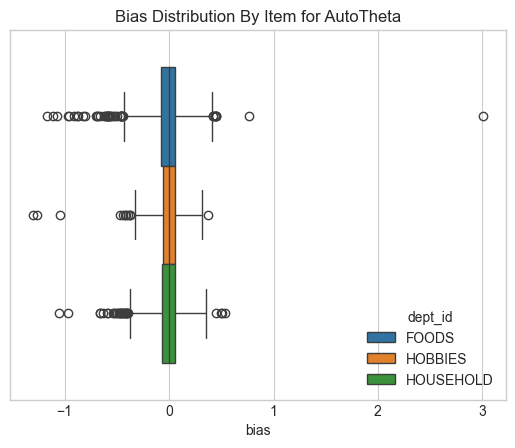

In [ ]:
# plot distibution of biases... 

sns.boxplot(
    data=best_model_long,
   hue='dept_id',
   x='bias',
   whis=2.5,
).set_title(f'Bias Distribution By Department for {MODEL}')

plt.show()

---
## SECTION 4: STABILITY ACROSS ORIGINS (PLANNER PAIN)

### The Fourth Question: Is the Model Stable Over Time?

Planners hate volatility. A model that's consistently 12% accurate is better than one that swings between 8% and 18% every week.

We measure stability using **standard deviation of wMAPE across cross-validation windows**.

In [134]:
# how stable is our model? for this we need our CV enriched 

calc = MetricsCalculator(
    anchor_model = "SN52",
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    cutoff_col="cutoff",
    model_col="model",
)

cutoff_metrics = calc.compute_metrics(
    df = best_model_cv,
    error_level=["item_id","cutoff"],
    metric_level="dept_id",
    metrics=["wmape","jitter"]
)

* Does our stddev is our distribution of wmape across cutoffs better than our naive baseline? 

In [135]:
jitter_pivot = cutoff_metrics.metric_level.pivot(index='dept_id',columns='model',values='jitter')

jitter_pivot = jitter_pivot.assign(stability_improvement_percent = jitter_pivot['SN52'].sub(jitter_pivot['AutoTheta']).mul(100))

display(jitter_pivot)

model,AutoTheta,Croston,SN52,stability_improvement_percent
dept_id,,,,
FOODS,0.0502,0.0122,0.0518,0.1557
HOBBIES,0.0080,0.0376,0.0847,7.6684
HOUSEHOLD,0.0171,0.0523,0.0647,4.7535


---
## SECTION 5: HORIZON DIAGNOSTICS (SHORT VS MID-TERM)

### The Second Question: Does Performance Decay by Horizon?

Different horizons drive different decisions.
- **Weeks 1-4 (Short Term):** Execution and replenishment
- **Weeks 5-13 (Mid Term):** Ordering and planning

If a model is great at week 1 but falls off a cliff at week 5, that matters.

In [136]:
# add a timestep column 
best_model_cv = best_model_cv.assign(
    # count timesteps 
    timestep = best_model_cv.groupby(["unique_id","cutoff","model"])["y"].cumcount().add(1),

    horizon_group = lambda df: np.where(df['timestep'].gt(5),"long_horizon","short_horizon"),
)


# get wmape and bias by horizon group
horizon_metrics = calc.compute_metrics(
    df = best_model_cv,
    error_level=["unique_id"],
    metric_level="horizon_group",
    metrics=["wmape"]
)


# get wmape and bias by timestep, we will just look at total level errors for this
timestep_metrics = calc.compute_metrics(
    df = best_model_cv,
    error_level=['item_id'],
    metric_level='timestep',
    metrics=['wmape','bias']
)

timestep_metrics

MetricResults(metric_level=    timestep      model  wmape    bias
0          1  AutoTheta 0.0254 -0.0026
1          1    Croston 0.0508 -0.0156
2          1       SN52 0.0527 -0.0527
3          2  AutoTheta 0.0706 -0.0706
4          2    Croston 0.0827 -0.0827
5          2       SN52 0.1045 -0.1045
6          3  AutoTheta 0.0529 -0.0529
7          3    Croston 0.0654 -0.0654
8          3       SN52 0.1097 -0.1097
9          4  AutoTheta 0.0375  0.0027
10         4    Croston 0.0346 -0.0083
11         4       SN52 0.1204 -0.1204
12         5  AutoTheta 0.0414  0.0100
13         5    Croston 0.0413 -0.0027
14         5       SN52 0.0819 -0.0819
15         6  AutoTheta 0.0914 -0.0805
16         6    Croston 0.0950 -0.0950
17         6       SN52 0.0949 -0.0949
18         7  AutoTheta 0.0900 -0.0678
19         7    Croston 0.0924 -0.0829
20         7       SN52 0.1012 -0.1012
21         8  AutoTheta 0.0789 -0.0408
22         8    Croston 0.0788 -0.0542
23         8       SN52 0.1337 -0.133

In [137]:
horizon_metrics.metric_level.pivot(
index='model',
columns='horizon_group',
values='wmape')

horizon_group,long_horizon,short_horizon
model,,
AutoTheta,0.0914,0.0298
Croston,0.0602,0.0420
SN52,0.0860,0.0942


# Do our errors go nuclear over time? 
    - almost always a forecasting models will compound errors over time, assessing the damage is important! 

In [138]:
# Lets plot our errors, how do they grow over time
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get unique models and metrics
models = timestep_metrics.metric_level['model'].unique()
metrics = ['wmape', 'bias']
n_metrics = len(metrics)

# Create subplots with one per metric
fig = make_subplots(
    rows=1, cols=n_metrics,
    subplot_titles=[f"<b>{metric.upper()}</b>" for metric in metrics],
    shared_yaxes=True,
    specs=[[{"secondary_y": False} for _ in metrics]]
)

# Color scheme for models
colors = {model: color for model, color in zip(models, 
          ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:len(models)])}

for j, metric in enumerate(metrics, 1):
    for model in models:
        model_data = timestep_metrics.metric_level[
            timestep_metrics.metric_level['model'] == model
        ]
        
        fig.add_trace(
            go.Scatter(
                x=model_data['timestep'],
                y=model_data[metric],
                name=model,
                mode='lines+markers',
                line=dict(color=colors[model], width=2),
                marker=dict(size=6),
                showlegend=(j == 1),  # Only show legend for first subplot
                hovertemplate=f"<b>{model}</b><br>Timestep: %{{x}}<br>{metric.upper()}: %{{y:.4f}}<extra></extra>"
            ),
            row=1, col=j
        )

# Add zero line only to bias subplot (column 2) with label
fig.add_hline(
    y=0,
    line_dash="dash",
    line_color="gray",
    row=1,
    col=2,
    annotation_text="Zero Bias (Ideal)",
    annotation_position="right",
    annotation_font_size=10,
    annotation_font_color="gray"
)

fig.update_layout(
    title=dict(
        text="<b>Error Metrics Over Time by Model</b>",
        x=0.5,
        xanchor='center',
        font=dict(size=16)
    ),
    height=500,
    width=1200,
    hovermode='x unified',
    template='plotly_white',
    font=dict(size=11),
    legend=dict(x=1.02, y=1, xanchor='left', yanchor='top')
)

# Update axes
for i in range(1, n_metrics + 1):
    fig.update_xaxes(title_text="<b>Timestep</b>", row=1, col=i)
fig.update_yaxes(title_text="<b>Error Value</b>", row=1, col=1)

fig.show()

- Given our strong look that we've had at the higher level it seems the proposed model is more stable and exhibits lower bias/wmape over time, let's now look at the lower level and see where our forecast might be failing tremendously on certain items and compare that to the anchor model. 

In [139]:
# get wmape and bias by timestep, we will just look at total level errors for this
item_metrics = calc.compute_metrics(
    df = best_model_cv,
    error_level=['item_id'],
    metric_level='item_id',
    metrics=['wmape','bias']
)

item_metrics_df = item_metrics.metric_level

# map dept id back to dataframe 

dept_mapping = best_model_cv[['item_id','dept_id']].drop_duplicates().set_index('item_id')['dept_id'].to_dict()

item_metrics_df['dept_id'] = item_metrics_df['item_id'].map(dept_mapping)

metric_dist = item_metrics_df.groupby(['model','dept_id'],as_index=False).agg(
    mean_wmape = ("wmape","mean"),
    q90_wmape = ("wmape",lambda x: x.quantile(.9)),
    q10_wmape = ("wmape",lambda x: x.quantile(.1)),
    mean_bias = ("bias",lambda x: x.abs().mean()),
    q90_bias = ("bias",lambda x: x.quantile(.9)),
    q10_bias = ("bias",lambda x: x.quantile(.1)),
)

In [140]:
import plotly.express as px

# Tail error comparison - wmape
wmape_data = metric_dist[['model', 'dept_id', 'q90_wmape']].copy()

fig1 = px.bar(
    wmape_data,
    x='dept_id',
    y='q90_wmape',
    color='model',
    barmode='group',
    title='Tail Forecast Error (90th %ile) by Department',
    labels={'q90_wmape': 'q90 wMAPE', 'dept_id': 'Department'},
    height=400
)
fig1.show()

# Bias comparison
bias_data = metric_dist[['model', 'dept_id', 'q90_bias']].copy()

fig2 = px.bar(
    bias_data,
    x='dept_id',
    y='q90_bias',
    color='model',
    barmode='group',
    title='Tail Bias (90th percentile) by Department',
    labels={'q90_bias': 'q90 Bias', 'dept_id': 'Department'},
    height=400
)
fig2.show()

# Clean comparison table - models as columns
comparison = metric_dist.pivot(index='dept_id', columns='model', values=['q90_wmape', 'q90_bias']).round(4)
display(comparison)


q90_wmape                 q90_bias               
model     AutoTheta Croston   SN52 AutoTheta Croston   SN52
dept_id                                                    
FOODS        0.5572  0.6069 0.6357    0.1127  0.1434 0.2685
HOBBIES      0.3854  0.4548 0.5238    0.1077  0.1131 0.1991
HOUSEHOLD    0.4369  0.5885 0.5727    0.0905  0.1336 0.2091

# Key Conclusions

* We learned alot from our ABC analysis when we inspect high order moments of the error distribution: 
    - our proposed model AutoTheta misses big occassionally on A items, and this is reinforced by having a kurtosis nearly twice the size of the competing models. The skew indicates we occasionally has severe overforecasting (long left tail). 
    - This deserves further investigation to be done in 2.07. Here we identified key failure points, now we dive deeper in the next section. 

* When examining the quantiles (.1,.9) of the errors, we gain confidence that although AutoTheta has heavy tails in the error distribution for A items, they seem to be very rare events that could be explained by promotional activities. 

* The plot across time also shows that these errors could be happening at the 13th week of forecasting where we see all models have a large jump in forecast error. In addition, when examining jitter (std of wmape) we see that AutoTheta has the most consistent WMAPE across cutoffs, by department when checking against our other models.